

<code style="background:red;color:white">Fast Food Marketing Campaign AB Test.</code>

# About Dataset

**Scenario**

* A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.

**Goal**

* Evaluate A/B testing results and decide which marketing strategy works the best.

**Columns**
* MarketID: unique identifier for market
* MarketSize: size of market area by sales
* LocationID: unique identifier for store location
* AgeOfStore: age of store in years
* Promotion: one of three promotions that were tested
* week: one of four weeks when the promotions were run
* SalesInThousands: sales amount for a specific LocationID, Promotion, and week

In [1]:

import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install statsmodels
import statsmodels.stats.api as sms
from scipy.stats import ttest_1samp, shapiro, levene, ttest_ind, mannwhitneyu, \
    pearsonr, spearmanr, kendalltau, f_oneway, kruskal
from statsmodels.stats.proportion import proportions_ztest

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
pd.set_option('display.float_format', lambda x: '%.5f' % x)



adrr="/kaggle/input/fast-food-marketing-campaign-ab-test/WA_Marketing-Campaign.csv"

data=pd.read_csv(adrr)


In [2]:
import warnings
warnings.filterwarnings("ignore")
#Ignore specific warnings by category
warnings.filterwarnings("ignore", category=FutureWarning)


In [3]:
df=data.copy()

In [4]:
def check_data(data,head=5):
    print(data.describe().T)
    print("****************shape***************************")
    #shape
    print(data.shape)
    print("***************info*******************")
    #data info
    print(data.info())
    print("***************valuecounts************")
    #value counts
    print(data.value_counts().head())
    print("*********na***********")
    print(data.isnull().sum())
    print("********data types******")
    print(data.dtypes)
    print("*******head******")
    print(df.head())




check_data(df)


                     count      mean       std      min       25%       50%  \
MarketID         548.00000   5.71533   2.87700  1.00000   3.00000   6.00000   
LocationID       548.00000 479.65693 287.97368  1.00000 216.00000 504.00000   
AgeOfStore       548.00000   8.50365   6.63835  1.00000   4.00000   7.00000   
Promotion        548.00000   2.02920   0.81073  1.00000   1.00000   2.00000   
week             548.00000   2.50000   1.11906  1.00000   1.75000   2.50000   
SalesInThousands 548.00000  53.46620  16.75522 17.34000  42.54500  50.20000   

                       75%       max  
MarketID           8.00000  10.00000  
LocationID       708.00000 920.00000  
AgeOfStore        12.00000  28.00000  
Promotion          3.00000   3.00000  
week               3.25000   4.00000  
SalesInThousands  60.47750  99.65000  
****************shape***************************
(548, 7)
***************info*******************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data

In [5]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)


In [6]:
cols=[col for col in df.columns if str(df[col].dtypes) in ["int64","float64"]]
cols

['MarketID',
 'LocationID',
 'AgeOfStore',
 'Promotion',
 'week',
 'SalesInThousands']

In [7]:
num_summary(df,cols)

                     count      mean       std      min       5%       10%  \
MarketID         548.00000   5.71533   2.87700  1.00000  1.00000   2.00000   
LocationID       548.00000 479.65693 287.97368  1.00000  7.35000 101.00000   
AgeOfStore       548.00000   8.50365   6.63835  1.00000  1.00000   1.00000   
Promotion        548.00000   2.02920   0.81073  1.00000  1.00000   1.00000   
week             548.00000   2.50000   1.11906  1.00000  1.00000   1.00000   
SalesInThousands 548.00000  53.46620  16.75522 17.34000 30.62150  35.41200   

                       20%       30%       40%       50%       60%       70%  \
MarketID           3.00000   4.00000   5.00000   6.00000   7.00000   8.00000   
LocationID       209.00000 301.00000 405.00000 504.00000 603.00000 701.00000   
AgeOfStore         3.00000   4.00000   5.00000   7.00000   8.00000  10.00000   
Promotion          1.00000   1.00000   2.00000   2.00000   2.00000   3.00000   
week               1.00000   2.00000   2.00000   2.50

In [8]:
cat_cols = [col for col in df.columns if df[col].dtypes == 'O']

cat_cols

['MarketSize']

Text(0.5, 1.0, 'Categorical Features')

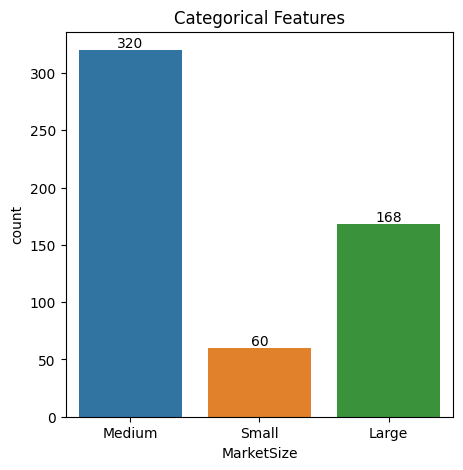

In [9]:
fig = plt.figure(figsize = (5,5))
ax = sns.countplot(df , x = 'MarketSize')
ax.bar_label(ax.containers[0])
plt.title('Categorical Features')

 ## Hypothesis: If market size is getting larger,our discount are becoming grow
> H0 = Market size doesn't affect sales


In [10]:
df.groupby("MarketSize").agg({"Promotion":["mean","count","sum"]})

Promotion           
                mean count  sum
MarketSize                     
Large        1.95238   168  328
Medium       2.06250   320  660
Small        2.06667    60  124

In [11]:
for col in df["MarketSize"].unique():
    test_stat, pvalue = shapiro(df.loc[df["MarketSize"] == col, "Promotion"])  # NORMAL DAGILIM
    print(col,"size market",'Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))


Medium size market Test Stat = 0.7928, p-value = 0.0000
Small size market Test Stat = 0.7716, p-value = 0.0000
Large size market Test Stat = 0.8021, p-value = 0.0000


   H0 s rejected

In [12]:

test_stat, pvalue = levene(df.loc[df["MarketSize"] == "Medium", "Promotion"],
                           df.loc[df["MarketSize"] == "Large", "Promotion"],
                           df.loc[df["MarketSize"] == "Small", "Promotion"])
print(pvalue)


0.26450725020374


H0 is accepted

## Nonparametric 

In [13]:
test_stat,pvalue=kruskal(df.loc[df["MarketSize"] == "Medium", "Promotion"],
                           df.loc[df["MarketSize"] == "Large", "Promotion"],
                           df.loc[df["MarketSize"] == "Small", "Promotion"])
print(pvalue)


0.3291372607787283



H0 is accepted

## Tukey


In [14]:

from statsmodels.stats.multicomp import MultiComparison
comparison = MultiComparison(df['Promotion'], df['MarketSize'])
tukey = comparison.tukeyhsd(0.90)
print(tukey.summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.90
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 Large Medium   0.1101 0.3283  0.0763 0.1439   True
 Large  Small   0.1143 0.6168   0.061 0.1676   True
Medium  Small   0.0042 0.9993 -0.0457  0.054  False
---------------------------------------------------


* Promotion -Sales

In [15]:
df["Promotion"].value_counts()

##Thre types value of promotions

Promotion
3    188
2    188
1    172
Name: count, dtype: int64

In [16]:
df.groupby("Promotion")["SalesInThousands"].mean()

Promotion
1   58.09901
2   47.32941
3   55.36447
Name: SalesInThousands, dtype: float64

In [17]:
df["Promotion"].corr(df.SalesInThousands)

-0.05921195055396623

In [18]:
for col in df["Promotion"].unique():
    test_stat, pvalue = shapiro(df.loc[df["Promotion"] == col, "SalesInThousands"])
print("P-value : {} \t H_0 reject : {}".format(p_value, p_value<0.05))

NameError: name 'p_value' is not defined

The p-value for the normal distribution hypothesis is below 0.05, leading us to reject the null hypothesis, which suggests that the assumption of a normal distribution is not met. Consequently, it is necessary to employ a non-parametric test.


In [ ]:
test_stat, p_value = kruskal(
                            df[df["Promotion"] == 1]["SalesInThousands"], 
                            df[df["Promotion"] == 2]["SalesInThousands"], 
                            df[df["Promotion"] == 3]["SalesInThousands"]
)

print("P-value : {} \t H_0 reject : {}".format(p_value, p_value<0.05))

h0 is rejected

In [ ]:
from statsmodels.stats.multicomp import MultiComparison
comparison = MultiComparison(df["SalesInThousands"],df["Promotion"])
tukey = comparison.tukeyhsd(0.05)
print(tukey.summary())

In [ ]:
## week

In [ ]:
df["week"].corr(df["Promotion"])

In [ ]:
for col in df["week"].unique():
    test_stat, pvalue = shapiro(df.loc[df["week"] == col, "Promotion"])  # NORMAL DAGILIM
    print(col,"size market",'Test Stat = %.4f, p-value = %.4f' % (test_stat, pvalue))


In [ ]:

test_stat, pvalue = levene(df.loc[df["week"] == 1, "Promotion"],
                           df.loc[df["week"] == 2, "Promotion"],
                           df.loc[df["week"] == 3, "Promotion"],
                          df.loc[df["week"] == 4, "Promotion"])
print(pvalue)


In [ ]:

test_stat, pvalue = kruskal(df.loc[df["week"] == 1, "Promotion"],
                           df.loc[df["week"] == 2, "Promotion"],
                           df.loc[df["week"] == 3, "Promotion"],
                          df.loc[df["week"] == 4, "Promotion"])
print(pvalue)


H0 is accepted